In [1]:
import ast
import intake
import intake_esm
from intake_esm import DerivedVariableRegistry
from pathlib import Path

import computations as comp
import plotting_methods as plm

import xarray as xr
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr
import cartopy.crs as ccrs

In [2]:
#
# parameters should go here
#
variables_to_plot = ["cltisccp", "cltmisr", "cltcalipso", "time_bnds"]

In [3]:
# land mask for CESM grid:
land = xr.open_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC']

In [4]:
# # 
# # Derived variables 
# # 

# # E3SM to CAM names
# e3sm_dvr = DerivedVariableRegistry()

# @e3sm_dvr.register(variable='SWCF', query={'variable':['rsut','rsutcs']})
# def e3sm_to_SWCF(ds):
#     ds['SWCF'] = ds['rsut'] - ds['rsutcs']
#     ds['SWCF'].attrs = {'units': 'W/m2', 'long_name': "shortwave cloud radiative effect",
#     "derived_by": "intake-esm"}
#     return ds

# @e3sm_dvr.register(variable='LWCF', query={'variable':['rsut','rsutcs']})
# def e3sm_to_LWCF(ds):
#     ds['LWCF'] = ds['rlut'] - ds['rlutcs']
#     ds['LWCF'].attrs = {'units': 'W/m2', 'long_name': "longwave cloud radiative effect",
#     "derived_by": "intake-esm"}
#     return ds


# @e3sm_dvr.register(variable='CLDTOT_CAL', query={'variable':['cltcalipso']})
# def e3sm_to_CLDTOT_CAL(ds):
#     ds['CLDTOT_CAL'] = ds['cltcalipso']
#     return ds

# @e3sm_dvr.register(variable='CLDTOT_CAL', query={'variable':['cltcalipso']})
# def e3sm_to_CLDTOT_CAL(ds):
#     ds['CLDTOT_CAL'] = ds['cltcalipso']
#     return ds

# # CAM to CMIP names
# cam_dvr = DerivedVariableRegistry()

# @cam_dvr.register(variable="cltisccp", query={'variable':['CLDTOT_ISCCP']})
# def cam_to_cltisccp(ds):
#     ds['cltisccp'] = ds['CLDTOT_ISCCP']
#     # check on units
#     return ds

# @cam_dvr.register(variable="cltmisr", query={'variable':['CLD_MISR']})
# def cam_to_cltmisr(ds):
#     tmp = ds['CLD_MISR'].sel(cosp_tau = slice(0.3, None)).sum(dim=('cosp_tau', 'cosp_htmisr'))
#     tmp.name = 'cltmisr'
#     tmp.attrs['long_name'] = 'MISR Total Cloud Fraction (tau > 0.3)'
#     ds['cltmisr'] = tmp
#     # check on units
#     return ds

# @cam_dvr.register(variable="cltcalipso", query={'variable':['CLDTOT_CAL']})
# def cam_to_cltcalipso(ds):
#     ds['cltcalipso'] = ds['CLDTOT_CAL']
#     # check on units
#     return ds


# @cam_dvr.register(variable="cltmodis", query={'variable':['CLTMODIS']})
# def cam_to_cltmodis(ds):
#     ds['cltmodis'] = ds['CLTMODIS']
#     # check on units
#     return ds


# # apply to observations:
# obs_dvr = DerivedVariableRegistry()

# # doesn't work ... probably b/c can't replace name of existing variable
# # @obs_dvr.register(variable="cltcalipso", query={'variable':['cltcalipso']})
# # def obs_to_cltcalipso(ds):
# #     ds['cltcalipso'] = 100.0 * ds['cltcalipso'] # to percent
# #     # check on units
# #     return ds




In [5]:
# dict of catalogs to use
rootdir = Path("/Volumes/Drudonna/")
catsfils = {
    "CAM4": rootdir / "cam4_1deg_release_amip" / "catalog" / "catalog_cam4_1deg_release_amip.json",
    "CAM5": rootdir / "cam5_1deg_release_amip" / "catalog" / "catalog_cam5_1deg_release_amip.json",
    "CAM6": rootdir / "f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1" / "catalog" / "catalog_f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.json",
    "E3SM": rootdir / "E3SM-1-0_amip" / "catalog" / "catalog_E3SM-1-0_amip.json",
    "OBS" : rootdir / "catalog_satellite_clouds_monthly.json"
}

# also define the derived variable registry:
dvr_objs = {"CAM4":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM5":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM6":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "E3SM":DerivedVariableRegistry.load("e3sm_derived_variable_registry"),
           "OBS":None}
csv_kw = {"CAM4":None, "CAM5":None, "CAM6":None, "E3SM":None, "OBS":{"converters": {"variable": ast.literal_eval}}}

cats = {c: intake.open_esm_datastore(str(catsfils[c]), registry=dvr_objs[c], read_csv_kwargs=csv_kw[c]) for c in catsfils}
print(cats)
cats_subset = {}
for c in cats:
    if c == 'E3SM':
        cats_subset[c] = cats[c].search(variable=variables_to_plot, member_id="r1i1p1f1")
    else:
        cats_subset[c] = cats[c].search(variable=variables_to_plot)
print(cats_subset)

{'CAM4': < catalog with 1 dataset(s) from 150 asset(s)>, 'CAM5': < catalog with 1 dataset(s) from 222 asset(s)>, 'CAM6': < catalog with 2 dataset(s) from 1003 asset(s)>, 'E3SM': < catalog with 2 dataset(s) from 234 asset(s)>, 'OBS': < catalog with 5 dataset(s) from 1126 asset(s)>}
{'CAM4': < catalog with 1 dataset(s) from 3 asset(s)>, 'CAM5': < catalog with 1 dataset(s) from 3 asset(s)>, 'CAM6': < catalog with 1 dataset(s) from 3 asset(s)>, 'E3SM': < catalog with 1 dataset(s) from 12 asset(s)>, 'OBS': < catalog with 3 dataset(s) from 176 asset(s)>}


In [6]:
%%time
dsets = {}
for c in cats_subset:
    dcod = True if c == "OBS" else False
    tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod})
    if len(tmp.keys()) == 1:
        dsets[c] = tmp[list(tmp.keys())[0]] # call it CAM/E3SM
    else:
        dsets = {**dsets, **tmp} # adds ISCCP/MISR/MODIS as keys



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source'


CPU times: user 1.87 s, sys: 938 ms, total: 2.81 s
Wall time: 2.23 s


In [7]:
%%time
dsets = {c: dsets[c].load() for c in dsets}

CPU times: user 59.1 s, sys: 11.8 s, total: 1min 10s
Wall time: 1min 17s


In [8]:
#
# hard-code a change in cltcalipso to percent
#
dsets['CALIPSO']['cltcalipso'] = 100.*dsets['CALIPSO']['cltcalipso']
dsets['CALIPSO']['cltcalipso'].attrs['units'] = "percent"

WITH SAA: 67.05935376059142 (67.05924775491924) 
 WITHOUT (2017->): 66.9083137179129 (66.97010784736395) 
 WITHOUT (all): 66.73477124633085 (66.95886381967826)


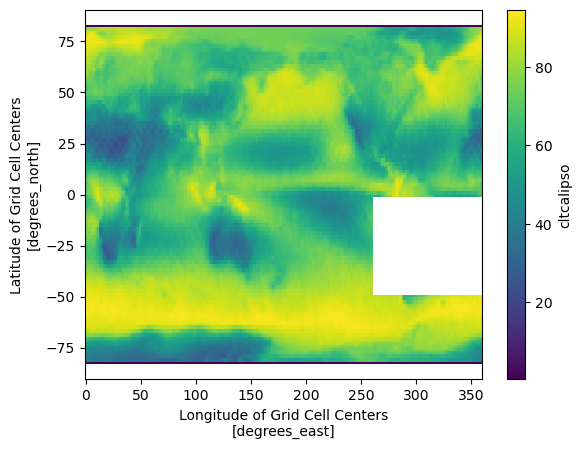

In [9]:
# CALIPSO - have to remove the South Atlantic Anomaly?
# This cell is just here to investigate the SAA impact on global mean cloud cover.
# 
cmpr = dsets['CALIPSO'].loc[{"lat": (dsets['CALIPSO']['lat'] < 49) & (dsets['CALIPSO']['lat'] > 1), "lon": (dsets['CALIPSO']['lon'] > 360-99)&(dsets['CALIPSO']['lon']<359)}]
cmpr_tavg = cmpr.weighted(np.cos(np.radians(cmpr['lat']))).mean(dim=('lat','lon'))

saa = dsets['CALIPSO'].loc[{"lat": (dsets['CALIPSO']['lat'] > -49) & (dsets['CALIPSO']['lat'] < -1), "lon": (dsets['CALIPSO']['lon'] > 360-99)&(dsets['CALIPSO']['lon']<359)}]
saa_tavg = saa.weighted(np.cos(np.radians(saa['lat']))).mean(dim=('lat','lon'))

# f2, a2 = plt.subplots()
# a2.plot(saa_tavg.time.dt.year+saa_tavg.time.dt.dayofyear/365, saa_tavg['cltcalipso']-saa_tavg['cltcalipso'].mean())
# a2.plot(cmpr_tavg.time.dt.year+cmpr_tavg.time.dt.dayofyear/365, cmpr_tavg['cltcalipso']-cmpr_tavg['cltcalipso'].mean())

cpy = dsets['CALIPSO']['cltcalipso'].copy()
cpy.loc[{"lat": (dsets['CALIPSO']['lat'] > -49) & (dsets['CALIPSO']['lat'] < -1), 
         "lon": (dsets['CALIPSO']['lon'] > 360-99)&(dsets['CALIPSO']['lon']<359),
         "time": dsets['CALIPSO'].time.dt.year >= 2017}] = np.nan


cpy2 = dsets['CALIPSO']['cltcalipso'].copy()
cpy2.loc[{"lat": (dsets['CALIPSO']['lat'] > -49) & (dsets['CALIPSO']['lat'] < -1), "lon": (dsets['CALIPSO']['lon'] > 360-99)&(dsets['CALIPSO']['lon']<359)}] = np.nan

cpy2.mean(dim='time').plot.pcolormesh()

orig_avg1 = comp.global_average(dsets['CALIPSO']['cltcalipso'], weights=None)
orig_avg2 = comp.global_average_np(dsets['CALIPSO']['cltcalipso'].values, np.cos(np.radians(dsets['CALIPSO']['lat'].values)), verbose=False)

cpy_avg1 = comp.global_average(cpy, weights=None)
cpy_avg2 = comp.global_average_np(cpy.values, np.cos(np.radians(cpy['lat'].values)), verbose=False)

cpy2_avg1 = comp.global_average(cpy2, weights=None)
cpy2_avg2 = comp.global_average_np(cpy2.values, np.cos(np.radians(cpy2['lat'].values)), verbose=False)


print(f"WITH SAA: {orig_avg1.item()} ({orig_avg2}) \n WITHOUT (2017->): {cpy_avg1.item()} ({cpy_avg2}) \n WITHOUT (all): {cpy2_avg1.item()} ({cpy2_avg2})")

#
# Conclusion
#
# For our purposes, I don't think removing the SAA region is important. It makes a small difference to the climatology.
# There may be a spurious trend, which is apparent after about 2017, but it is small for cltcalipso.
# Possibly more important for clhcalipso? 

In [10]:
#
# misr 
#
# land.shape

# Check to make sure lat goes -90-90
if dsets['MISR']['lat'][1] < dsets['MISR']['lat'][0]:
    print('need to reverse')
    dsets['MISR'] = dsets['MISR'].reindex(lat=list(reversed(dsets['MISR']['lat'])))
else:
    print("MISR lat increasing")

# print(dsets['MISR'].coords)
# print(land.coords)

# manually remove the land values from MISR

dsets['MISR'] = xr.where(land.squeeze().values>0, np.nan, dsets['MISR'])



MISR lat increasing


In [11]:
#
# time-average fields
#

tavg = {}

tslice = slice("2001-01-01", "2020-12-31")

for c in dsets:
    if 'time_bnds' in dsets[c]:
        print(f"{c} has time_bnds")
        tmp = comp.adjust_monthly_time(dsets[c])  # note: has to be in-memory to do the averaging
        dsets[c] = tmp.load() 
    else:
        print(f"{c} does not have time_bnds")
        dsets[c] = dsets[c].load()
    tmp = dsets[c].sel(time=tslice)
    print(f"{c} Full time range: {dsets[c].time.min().dt.strftime('%Y-%m').item()}-{dsets[c].time.max().dt.strftime('%Y-%m').item()}")
    print(f"\t{c} Sample time range: {tmp.time.min().dt.strftime('%Y-%m').item()}-{tmp.time.max().dt.strftime('%Y-%m').item()}")
    try:
        tavg[c] = tmp.weighted(tmp.time.dt.daysinmonth).mean(dim='time')
    except:
        print(f"problem with {c}:\n{print(dsets[c])}")

CAM4 has time_bnds
CAM4 Full time range: 2000-11-2010-12
	CAM4 Sample time range: 2001-01-2010-12
CAM5 has time_bnds
CAM5 Full time range: 2001-01-2010-12
	CAM5 Sample time range: 2001-01-2010-12
CAM6 has time_bnds
CAM6 Full time range: 1979-01-2014-12
	CAM6 Sample time range: 2001-01-2014-12
E3SM has time_bnds
E3SM Full time range: 1870-01-2014-12
	E3SM Sample time range: 2001-01-2014-12
MISR does not have time_bnds
MISR Full time range: 2000-03-2021-11
	MISR Sample time range: 2001-01-2020-12
ISCCP does not have time_bnds
ISCCP Full time range: 1983-07-2017-06
	ISCCP Sample time range: 2001-01-2017-06
CALIPSO does not have time_bnds
CALIPSO Full time range: 2006-06-2020-12
	CALIPSO Sample time range: 2006-06-2020-12


In [12]:
# global averages
gavg = {}
ocn_avg = {}
lnd_avg = {}

for c in tavg:
    print(f"c = {c} --> {'lat' in tavg[c].dims}")
    if 'lat' not in tavg[c].dims:
        tavg[c] = tavg[c].rename({"latitude":"lat", "longitude":"lon"})
    else:
        print("Did not adjust dimension names")
    gavg[c] = comp.global_average(tavg[c])
    
print("gavg done")
#
# make land and ocean averages separate
#
for ob in ['ISCCP', 'MISR', 'CALIPSO']:
    print(f"ocn/lnd : {ob}  -- in tavg: {ob in tavg} --> type: {type(tavg[ob])}")
    print(f" --> {ob} in data_vars: {ob in tavg[ob].data_vars}")
    print(f" --> {'clt'+ob.lower()} in data_vars: {'clt'+ob.lower() in tavg[ob].data_vars}")
    tmp = tavg[ob]['clt'+ob.lower()]
    print(f"shape: {tmp.shape}")
    print(tmp.coords)
    # print(f"[{ob}] {tmp} --> {tmp.dims}")
    if tmp['lat'].size != land['lat'].size:
        print(f"{ob}: tmp lat is {tmp['lat'].size}, land lat is {land['lat'].size}")
        tmp = tmp.interp_like(land)
    if not np.all(tmp['lat'].values == land['lat'].values):  # there are tiny diffs in lat/lon
        print(f"Need to interpolate {ob}")
        tmp = tmp.interp_like(land)

    ocn_avg[ob] = comp.global_average(
        xr.where(
            land.squeeze() > 0, 
            np.nan, 
            tmp)
            )
    lnd_avg[ob] = comp.global_average(
        xr.where(
            land.squeeze() <= 0, 
            np.nan, 
            tmp)
        )
print("-- lnd/ocn done -- ")
# set titles
obs_title = {}
for ob in ['ISCCP', 'MISR', 'CALIPSO']:
    v = 'clt'+ob.lower()
    print(f"v = {v} --> {gavg[ob][v]}")
    if not np.isnan(lnd_avg[ob]):
        obs_title[ob] = f"Avg: {gavg[ob][v].item():4.1f}, Ocean: {ocn_avg[ob].item():4.1f}, Land: {lnd_avg[ob].item():4.1f}"
    else:
        obs_title[ob] = f"Avg: {gavg[ob][v].item():4.1f}"


c = CAM4 --> True
Did not adjust dimension names
c = CAM5 --> True
Did not adjust dimension names
c = CAM6 --> True
Did not adjust dimension names
c = E3SM --> True
Did not adjust dimension names
c = MISR --> True
Did not adjust dimension names
c = ISCCP --> True
Did not adjust dimension names
c = CALIPSO --> True
Did not adjust dimension names
gavg done
ocn/lnd : ISCCP  -- in tavg: True --> type: <class 'xarray.core.dataset.Dataset'>
 --> ISCCP in data_vars: False
 --> cltisccp in data_vars: True
shape: (192, 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
ocn/lnd : MISR  -- in tavg: True --> type: <class 'xarray.core.dataset.Dataset'>
 --> MISR in data_vars: False
 --> cltmisr in data_vars: True
shape: (192, 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 

In [13]:
# Label will be bias & rmse
# bias is the global average of the climo difference

bias_dict = {}
rmse_dict = {}
errstr = {}

for model in ['CAM4', 'CAM5', 'CAM6', 'E3SM']:
    bias_dict[model] = {}
    rmse_dict[model] = {}
    errstr[model] = {}
    for ob in ['ISCCP', 'MISR', 'CALIPSO']:
        v = 'clt'+ob.lower()
        if v in tavg[model]:
            bias_dict[model][ob] = comp.bias(tavg[model][v], tavg[ob][v])
            rmse_dict[model][ob] = comp.wgt_rmse(tavg[model][v], tavg[ob][v])
            errstr[model][ob] = f"Bias: {bias_dict[model][ob]:3.1f}, RMSE: {rmse_dict[model][ob]:3.1f}" 
            

bias_dict_6060 = {}
rmse_dict_6060 = {}
errstr_6060 = {}

for model in ['CAM4', 'CAM5', 'CAM6', 'E3SM']:
    bias_dict_6060[model] = {}
    rmse_dict_6060[model] = {}
    errstr_6060[model] = {}
    for ob in ['ISCCP', 'MISR', 'CALIPSO']:
        v = 'clt'+ob.lower()
        if v in tavg[model]:
            bias_dict_6060[model][ob] = comp.bias(tavg[model][v].sel(lat=slice(-60,60)), tavg[ob][v].sel(lat=slice(-60,60)))
            rmse_dict_6060[model][ob] = comp.wgt_rmse(tavg[model][v].sel(lat=slice(-60,60)), tavg[ob][v].sel(lat=slice(-60,60)))
            errstr_6060[model][ob] = f"Bias: {bias_dict_6060[model][ob]:3.1f}, RMSE: {rmse_dict_6060[model][ob]:3.1f}" 
        
[print(f'{c} : {errstr[c]}') for c in errstr]
[print(f'{c} : {errstr_6060[c]}') for c in errstr_6060]
# Compares whether full global vs 60S-60N matters;
# result: values change a little, but doesn't matter much. CAM5 v CAM6 for MISR bias switches, but they are close.

CAM4 : {'ISCCP': 'Bias: -26.0, RMSE: 28.6', 'MISR': 'Bias: -27.0, RMSE: 29.3', 'CALIPSO': 'Bias: -24.5, RMSE: 26.5'}
CAM5 : {'ISCCP': 'Bias: -14.8, RMSE: 16.9', 'MISR': 'Bias: -12.3, RMSE: 16.4', 'CALIPSO': 'Bias: -9.1, RMSE: 11.6'}
CAM6 : {'ISCCP': 'Bias: -11.5, RMSE: 16.8', 'MISR': 'Bias: -11.8, RMSE: 19.3', 'CALIPSO': 'Bias: -9.7, RMSE: 15.1'}
E3SM : {'ISCCP': 'Bias: -10.2, RMSE: 15.6', 'CALIPSO': 'Bias: -6.9, RMSE: 12.1'}
CAM4 : {'ISCCP': 'Bias: -28.4, RMSE: 29.8', 'MISR': 'Bias: -28.0, RMSE: 29.8', 'CALIPSO': 'Bias: -25.7, RMSE: 27.1'}
CAM5 : {'ISCCP': 'Bias: -14.8, RMSE: 16.6', 'MISR': 'Bias: -12.4, RMSE: 15.6', 'CALIPSO': 'Bias: -9.5, RMSE: 11.7'}
CAM6 : {'ISCCP': 'Bias: -13.9, RMSE: 17.5', 'MISR': 'Bias: -13.4, RMSE: 19.3', 'CALIPSO': 'Bias: -11.1, RMSE: 15.5'}
E3SM : {'ISCCP': 'Bias: -12.3, RMSE: 15.9', 'CALIPSO': 'Bias: -8.4, RMSE: 11.9'}


[None, None, None, None]

DIFFERENCE 1: -14.758161558606268
DIFFERENCE 2: <xarray.DataArray 'cltisccp' ()>
array(-15.0387436)
Coordinates:
    P0       float64 1e+05
    ntrm     int32 1
    ntrn     int32 1
    ntrk     int32 1
    ndbase   int32 0
    nsbase   int32 0
    nbdate   int32 19981001
    nbsec    int32 0
    mdt      int32 1800


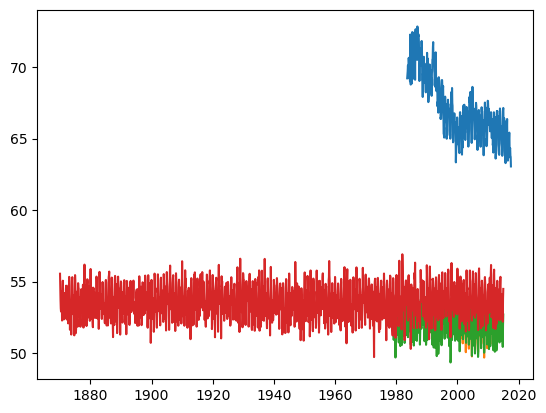

In [14]:
# compare all-time bias vs overlap-time bias
difference = tavg['CAM5']['cltisccp'] - tavg['ISCCP']['cltisccp']
print(f"DIFFERENCE 1: {comp.global_average(difference).item()}")

tmin = dsets['CAM5'].time.min().dt.strftime("%Y-%m")
tmax = dsets['CAM5'].time.max().dt.strftime("%Y-%m")

def month_avg(da):
    month_length = da.time.dt.days_in_month
    return da.weighted(month_length).mean(dim='time')

overlap_tavg = month_avg(dsets['ISCCP']['cltisccp'].sel(time=slice(tmin,tmax)))
print(f"DIFFERENCE 2: {comp.global_average(tavg['CAM5']['cltisccp'] - overlap_tavg)}")
# print(dsets['CAM5'].time.min())

# compare the global mean time series... just to see what that looks like:
f0, a0 = plt.subplots()
taxis0 = dsets['ISCCP']['cltisccp'].time.dt.year + (dsets['ISCCP']['cltisccp'].time.dt.month / 12)
tmp0 = dsets['ISCCP']['cltisccp'].sel(lat=slice(-60,60))
tseries0 = tmp0.weighted(np.cos(np.radians(tmp0.lat))).mean(dim=("lat","lon"))

tmp1 = dsets['CAM5']['cltisccp'].sel(lat=slice(-60,60))
taxis1 = dsets['CAM5']['cltisccp'].time.dt.year + (dsets['CAM5']['cltisccp'].time.dt.month / 12)
tseries1 = tmp1.weighted(np.cos(np.radians(tmp1.lat))).mean(dim=("lat","lon"))

tmp2 = dsets['CAM6']['cltisccp'].sel(lat=slice(-60,60))
taxis2 = dsets['CAM6']['cltisccp'].time.dt.year + (dsets['CAM6']['cltisccp'].time.dt.month / 12)
tseries2 = tmp2.weighted(np.cos(np.radians(tmp2.lat))).mean(dim=("lat","lon"))

tmp3 = dsets['E3SM']['cltisccp'].sel(lat=slice(-60,60))
taxis3 = dsets['E3SM']['cltisccp'].time.dt.year + (dsets['E3SM']['cltisccp'].time.dt.month / 12)
tseries3 = tmp3.weighted(np.cos(np.radians(tmp3.lat))).mean(dim=("lat","lon"))

a0.plot(taxis0, tseries0)
a0.plot(taxis1, tseries1)
a0.plot(taxis2, tseries2)
a0.plot(taxis3, tseries3)


# print(dsets['CAM5']['cltisccp'].isel(time=0).weighted(np.cos(np.radians(dsets['CAM5']['cltisccp'].lat))).mean(dim=("lon","lat")).item())

# weights = (np.cos(np.radians(dsets['CAM5']['cltisccp'].lat))).broadcast_like(dsets['CAM5']['cltisccp'].isel(time=0))
# weights = xr.where(np.isnan(dsets['CAM5']['cltisccp'].isel(time=0)), np.nan, weights )
# print( (dsets['CAM5']['cltisccp'].isel(time=0) * weights).sum() / weights.sum())

File already exists ... specify whether to overwrite: False.
Did not save output file.


/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/brianpm/opt/miniconda3/envs/p11/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
 

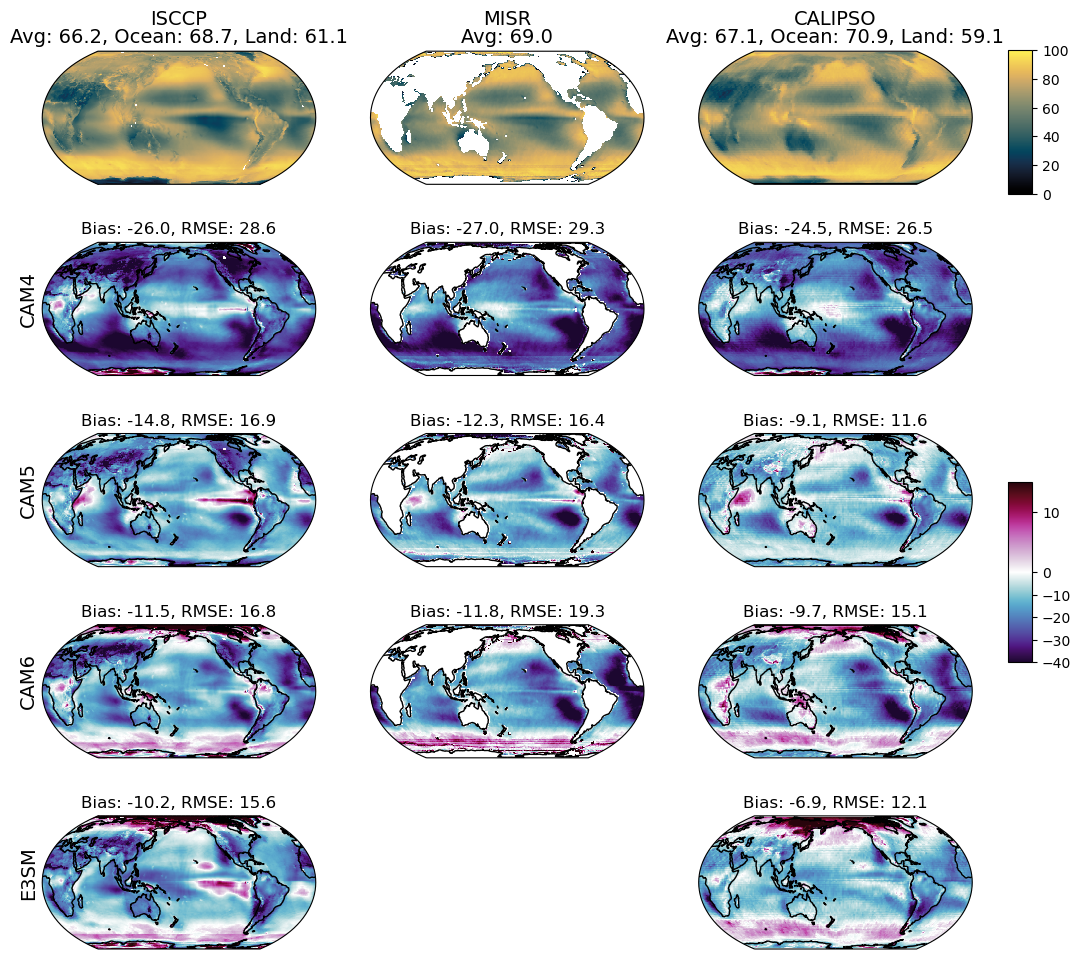

In [16]:
#
# starting from code in cam456_global_cloudcover.ipynb
#
models = ['CAM4', 'CAM5', 'CAM6', 'E3SM']

fs = 14
fw = 'normal'
clrmap = 'cmr.eclipse'
dclrmap = 'cmr.viola'
cnorm = mpl.colors.Normalize(vmin=0.0, vmax=100.0)
dnorm = mpl.colors.TwoSlopeNorm(vmin=-40, vcenter=0.0, vmax=15.0)
sm1 = mpl.cm.ScalarMappable(norm=cnorm, cmap=clrmap)
sm2 = mpl.cm.ScalarMappable(norm=dnorm, cmap='cmr.viola')

fig, axs = plt.subplots(figsize=(12,12), nrows=len(models)+1, ncols=3, subplot_kw={'projection':ccrs.EqualEarth(central_longitude=180)})

isccp_mlon, isccp_mlat = np.meshgrid(tavg['ISCCP']['lon'], tavg['ISCCP']['lat'])
axs[0,0].pcolormesh(
    isccp_mlon, 
    isccp_mlat, 
    tavg['ISCCP']['cltisccp'], 
    transform=ccrs.PlateCarree(), norm=cnorm, rasterized=True, cmap=clrmap)
axs[0,0].set_title(obs_title['ISCCP'], fontsize=fs, fontweight=fw)
misr_mlon, misr_mlat = np.meshgrid(tavg['MISR']['lon'], tavg['MISR']['lat'])
axs[0,1].pcolormesh(misr_mlon, misr_mlat, tavg['MISR']['cltmisr'], transform=ccrs.PlateCarree(), norm=cnorm, rasterized=True, cmap=clrmap)
axs[0,1].set_title(obs_title['MISR'], fontsize=fs, fontweight=fw)
cal_mlon, cal_mlat = np.meshgrid(tavg['CALIPSO']['lon'], tavg['CALIPSO']['lat'])
axs[0,2].pcolormesh(cal_mlon, cal_mlat, tavg['CALIPSO']['cltcalipso'], transform=ccrs.PlateCarree(), norm=cnorm, rasterized=True, cmap=clrmap)
axs[0,2].set_title(obs_title['CALIPSO'], fontsize=fs, fontweight=fw)
#
# MODEL MINUS SATELLITE
# 
for row, model in enumerate(models, start=1):
    mod_mlon, mod_mlat = np.meshgrid(tavg[model]['lon'], tavg[model]['lat'])
    for col, src in enumerate(['ISCCP', 'MISR', 'CALIPSO']):
        v = 'clt'+src.lower()
        if v in tavg[model]:
            if True:
                axs[row,col].pcolormesh(
                    mod_mlon, 
                    mod_mlat, 
                    tavg[model][v] - tavg[src][v].interp_like(tavg[model][v]), # PREFER TO HAVE ALL ON CORRECT GRID BEFORE THIS
                    transform=ccrs.PlateCarree(), norm=dnorm, rasterized=True, cmap=dclrmap)
            axs[row,col].set_title(errstr[model][src])
            axs[row,col].coastlines()
        else:
            axs[row,col].axis('off')
#
cax1 = fig.add_axes([0.93, .75, 0.02, 0.12])
cax2 = fig.add_axes([0.93, .36, 0.02, 0.15])
cbar = fig.colorbar(sm1, cax=cax1, orientation='vertical')
cbar2 = fig.colorbar(sm2, cax=cax2, orientation='vertical')
#
# text for the columns 
# ** these are hand-tuned values that only work for this shape ... would be nicer to have something flexible
for col, tistr in enumerate(['ISCCP', 'MISR', 'CALIPSO']):
    axs[0,col].text(0.5, 1.2, tistr, ha='center', fontweight=fw, fontsize=fs, transform=axs[0,col].transAxes)
for row, modstr in enumerate(models, start=1):
    axs[row, 0].text(-0.05, 0.4, modstr, ha='center', rotation=90, fontweight=fw, fontsize=fs, transform=axs[row,0].transAxes)

plotfilename = "/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/clt_maps_comparison.pdf"
plm.fig_output(fig, plotfilename, clobber_fig=False)

In [17]:
#
# NMSE bar charts
#
models = ['CAM4', 'CAM5', 'CAM6', 'E3SM']
nmse_results = {}
for m in models:
    nmse_results[m] = {}
    for s in ["ISCCP", "MISR", "CALIPSO"]:
        v = 'clt'+s.lower()
        if v in tavg[m]:
            # u, c, p, svr 
            modelmasked = xr.where(np.isnan(tavg[s][v]), np.nan, tavg[m][v].values)
            nmse_results[m][s] = comp.nmse_components(modelmasked.sel(lat=slice(-60,60)), tavg[s][v].sel(lat=slice(-60,60)), weights=None, is_averaged=True)
        else:
            nmse_results[m][s] = (np.nan, np.nan, np.nan, np.nan)


col = 0, s = ISCCP
col = 1, s = MISR
col = 2, s = CALIPSO
File already exists ... specify whether to overwrite: False.
Did not save output file.


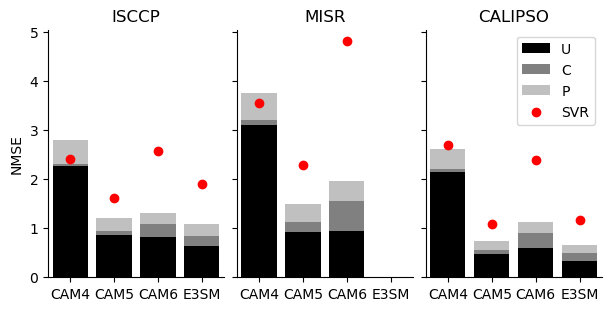

In [19]:
# plot the NMSE
fignmse, axnmse = plt.subplots(figsize=(6,3), ncols=3, constrained_layout=True, sharey=True)
clr1 = 'black'
clr2 = 'gray'
clr3 = 'silver'

xlocs = np.arange(1, len(models)+1)
bars = []
for col, s in enumerate(["ISCCP", "MISR", "CALIPSO"]):
    print(f"col = {col}, s = {s}")
    bars.append(
        axnmse[col].bar(xlocs, [nmse_results[m][s][0] for m in models], color=clr1) # unconditional
    )
    bars.append(
        axnmse[col].bar(xlocs, [nmse_results[m][s][1] for m in models], color=clr2, 
                    bottom=[nmse_results[m][s][0] for m in models]) # conditional
    )
    bars.append(axnmse[col].bar(xlocs, [nmse_results[m][s][2] for m in models], color=clr3, 
                    bottom=[nmse_results[m][s][0]+nmse_results[m][s][1] for m in models]) # phase
    )
    bars.append(
        axnmse[col].scatter(xlocs, [nmse_results[m][s][3] for m in models], marker='o', color='red', zorder=10) # scaled variance ratio
    )
    axnmse[col].set_title(s)

axnmse[2].legend(bars, ["U","C","P","SVR"]) # generate legend separately
for a in axnmse:
    a.set_xticks(xlocs)
    a.set_xticklabels(models)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim([0.5, len(models)+0.5])
axnmse[0].set_ylabel("NMSE")
plotfilename = "/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456e3sm_clt_nmse.pdf"
plm.fig_output(fignmse, plotfilename, clobber_fig=False)

col = 0, s = ISCCP
col = 1, s = MISR
col = 2, s = CALIPSO
File already exists ... specify whether to overwrite: False.
Did not save output file.


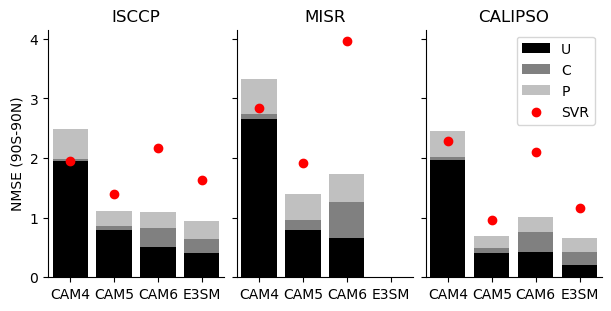

In [22]:
# Repeat NMSE for global domain

region = slice(-90,90)

nmse_results = {}
for m in models:
    nmse_results[m] = {}
    for s in ["ISCCP", "MISR", "CALIPSO"]:
        v = 'clt'+s.lower()
        if v in tavg[m]:
            # u, c, p, svr 
            modelmasked = xr.where(np.isnan(tavg[s][v]), np.nan, tavg[m][v].values)
            nmse_results[m][s] = comp.nmse_components(modelmasked.sel(lat=region), tavg[s][v].sel(lat=region), weights=None, is_averaged=True)
        else:
            nmse_results[m][s] = (np.nan, np.nan, np.nan, np.nan)


# plot the NMSE
fignmse, axnmse = plt.subplots(figsize=(6,3), ncols=3, constrained_layout=True, sharey=True)
clr1 = 'black'
clr2 = 'gray'
clr3 = 'silver'

xlocs = np.arange(1, len(models)+1)
bars = []
for col, s in enumerate(["ISCCP", "MISR", "CALIPSO"]):
    print(f"col = {col}, s = {s}")
    bars.append(
        axnmse[col].bar(xlocs, [nmse_results[m][s][0] for m in models], color=clr1) # unconditional
    )
    bars.append(
        axnmse[col].bar(xlocs, [nmse_results[m][s][1] for m in models], color=clr2, 
                    bottom=[nmse_results[m][s][0] for m in models]) # conditional
    )
    bars.append(axnmse[col].bar(xlocs, [nmse_results[m][s][2] for m in models], color=clr3, 
                    bottom=[nmse_results[m][s][0]+nmse_results[m][s][1] for m in models]) # phase
    )
    bars.append(
        axnmse[col].scatter(xlocs, [nmse_results[m][s][3] for m in models], marker='o', color='red', zorder=10) # scaled variance ratio
    )
    axnmse[col].set_title(s)

axnmse[2].legend(bars, ["U","C","P","SVR"]) # generate legend separately
for a in axnmse:
    a.set_xticks(xlocs)
    a.set_xticklabels(models)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim([0.5, len(models)+0.5])
axnmse[0].set_ylabel("NMSE (90S-90N)")
plotfilename = "/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456e3sm_clt_nmse_g90.pdf"
plm.fig_output(fignmse, plotfilename, clobber_fig=False)